### Imports and Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import io
import requests
import os

from scipy.stats import zscore
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from IPython.display import display

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt

Panda Preferences

In [2]:
# Set options for displaying maximum columns and rows
pd.set_option('display.max_columns', None)  
#pd.set_option('display.max_rows', None)

**Read CSV**

In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv("../../../Datasets/Flows/iomt_flows.csv")

# Display the DataFrame
display(df)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,traffic,is_attack
0,10.10.10.252,56248,224.0.0.251,5353,udp,dns,-,-,-,S0,T,F,0,D,1,78,0,0,-,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,50.0,50.0,50.0,50.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,50.0,50.0,50.0,50.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,arpspoofing,1
1,10.10.10.252,50214,224.0.0.251,5353,udp,dns,-,-,-,S0,T,F,0,D,1,74,0,0,-,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,46.0,46.0,46.0,46.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,46.0,46.0,46.0,46.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,arpspoofing,1
2,10.10.10.252,58369,224.0.0.251,5353,udp,dns,-,-,-,S0,T,F,0,D,1,73,0,0,-,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,45.0,45.0,45.0,45.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,45.0,45.0,45.0,45.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,arpspoofing,1
3,10.10.10.252,57377,224.0.0.251,5353,udp,dns,-,-,-,S0,T,F,0,D,1,74,0,0,-,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,46.0,46.0,46.0,46.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,46.0,46.0,46.0,46.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,arpspoofing,1
4,10.10.10.252,12345,224.0.0.251,5353,udp,dns,-,-,-,S0,T,F,0,D,1,74,0,0,-,0.000000,1,0,1,0,0.000000,0.000000,0.000000,0.000000,8,8,8,0,0,0,0,0,0,

Fix Dataframe Mixed Types

In [4]:
df.groupby('is_attack')['is_attack'].count()

is_attack
0     766915
1    2476273
Name: is_attack, dtype: int64

In [5]:
df.groupby('traffic')['traffic'].count()

traffic
apachekiller      84579
arpspoofing       11236
camoverflow     1640039
mqttmalaria       69623
netscan          467093
normal           766915
rudeadyet        131081
slowloris         63608
slowread           9014
Name: traffic, dtype: int64

In [6]:
df = df.drop('duration', axis=1)

In [7]:
df.groupby('is_attack')['is_attack'].count()

is_attack
0     766915
1    2476273
Name: is_attack, dtype: int64

In [45]:
df.groupby('traffic')['traffic'].count()

flow_duration
-0.289776    1749419
-0.289734       7039
-0.289752       5320
-0.289727       4778
-0.289733       4742
-0.289726       4594
-0.289735       4140
-0.289712       4004
-0.289709       3984
-0.289748       3948
-0.289725       3807
-0.289710       3793
-0.289713       3727
-0.289724       3711
-0.289703       3670
-0.289732       3621
-0.289700       3614
-0.289688       3600
-0.289685       3572
-0.289711       3549
-0.289728       3518
-0.289702       3497
-0.289689       3451
-0.289708       3451
-0.289723       3444
-0.289686       3437
-0.289683       3415
-0.289701       3414
-0.289682       3414
-0.289699       3375
-0.289731       3369
-0.289684       3340
-0.289668       3298
-0.289687       3283
-0.289697       3195
-0.289751       3180
-0.289698       3180
-0.289704       3135
-0.289672       3081
-0.289661       3076
-0.289681       3075
-0.289671       3068
-0.289669       3064
-0.289667       3037
-0.289670       3019
-0.289696       3013
-0.289660       2998

-----------------------------------------------------------

## DF Statistics and Info

In [9]:
def display_information_dataframe(df_cop):
    # Create a summary of data types, column names, and unique values
    summary_data = [{'Data Type': dtype, 'Column Name': col, 'Unique Values': df_cop[col].unique()} for col, dtype in df_cop.dtypes.iteritems()]
    
    # Create a DataFrame from the summary data
    summary_df = pd.DataFrame(summary_data)
    
    # Set display options to show all rows and columns
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    
    # Return the summary DataFrame
    return summary_df

In [10]:
display_information_dataframe(df)

,Data Type,Column Name,Unique Values
0,object,id.orig_h,"[10.10.10.252, 10.10.10.247, ::1, 10.10.10.248..."
1,int64,id.orig_p,"[56248, 50214, 58369, 57377, 12345, 40674, 571..."
2,object,id.resp_h,"[224.0.0.251, 10.10.10.0, 10.10.10.249, 10.10...."
3,int64,id.resp_p,"[5353, 137, 57621, 22, 5683, 1883, 123, 53, 56..."
4,object,proto,"[udp, tcp, icmp]"
5,object,service,"[dns, -, mqtt, dhcp, http]"
6,object,orig_bytes,"[-, 90, 170, 579, 1608, 583, 580, 80, 88, 135,..."
7,object,resp_bytes,"[-, 0, 477, 94, 300, 1200, 509, 571, 400, 6, 4..."
8,object,conn_state,"[S0, OTH, SHR, SF, SH, REJ, RSTR, S1, RSTOS0, ..."
9,object,local_orig,"[T, F]"


--------------------------------------------

## Pre-processing and Data Encoding

Split History

In [11]:
def count_letters(string, is_upper):
    count = 0
    
    # Iterate through each character in the string
    for c in string:
        if is_upper and c.isupper():  # Check if the character is uppercase
            count += 1
        elif not is_upper and c.islower():  # Check if the character is lowercase
            count += 1
    
    return count

In [12]:
print('[SPLIT HISTORY] history_originator')
df['history_originator'] = df['history'].apply(lambda x: count_letters(x, True))

print('[SPLIT HISTORY] history_responder')
df['history_responder'] = df['history'].apply(lambda x: count_letters(x, False))

[SPLIT HISTORY] history_originator
[SPLIT HISTORY] history_responder


Decimal Scale Normalization

In [13]:
# Multiply by 1000 for a bigger scale
print('[DECIMAL SCALE NORMALIZATION] flow_duration')
df['flow_duration'] *= 1000

[DECIMAL SCALE NORMALIZATION] flow_duration


Data Normalization

In [14]:
# Update values in 'bwd_PSH_flag_count' column if they are higher than 4
print('[DATA NORMALIZATION] bwd_PSH_flag_count')
df.loc[df['bwd_PSH_flag_count'] > 4, 'bwd_PSH_flag_count'] = 5

[DATA NORMALIZATION] bwd_PSH_flag_count


Remove Outliers

In [15]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print(f'[REMOVED OUTLIERS] {col}')
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [16]:
outliers = [
    'flow_duration',
    'bwd_pkts_payload.avg',
    'bwd_header_size_tot',
    'missed_bytes',
    
    'fwd_pkts_tot',
    'fwd_header_size_tot',
    'flow_pkts_payload.tot',
    
    'fwd_last_window_size',
    'fwd_init_window_size',
    'bwd_last_window_size',
    'bwd_init_window_size',
]

df = remove_outliers(df, outliers, 3)

[REMOVED OUTLIERS] flow_duration
[REMOVED OUTLIERS] bwd_pkts_payload.avg
[REMOVED OUTLIERS] bwd_header_size_tot
[REMOVED OUTLIERS] missed_bytes
[REMOVED OUTLIERS] fwd_pkts_tot
[REMOVED OUTLIERS] fwd_header_size_tot
[REMOVED OUTLIERS] flow_pkts_payload.tot
[REMOVED OUTLIERS] fwd_last_window_size
[REMOVED OUTLIERS] fwd_init_window_size
[REMOVED OUTLIERS] bwd_last_window_size
[REMOVED OUTLIERS] bwd_init_window_size


One Hot Encoding

In [17]:
def one_hot_encoding(df, columns):
    for col in columns:
        print(f'[ONE HOT ENCODING] {col}')
        df = pd.get_dummies(df, columns=[col], prefix=col)  # Perform one-hot encoding on the column
    
    return df

In [18]:
cols_to_encode = [
    'local_resp',
    'local_orig',
]

df = one_hot_encoding(df,cols_to_encode)

[ONE HOT ENCODING] local_resp
[ONE HOT ENCODING] local_orig


In [19]:
# Define a mapping of values to replace
fwd_header_size_min_map = {0: 0, 8: 1, 20: 2, 24: 3, 32: 4, 36: 5, 40: 6, 44: 7}
fwd_header_size_max_map = {0: 0, 8: 1, 20: 2, 24: 3, 32: 4, 36: 5, 40: 6, 44: 7}
bwd_header_size_min_map = {0: 0, 8: 1, 20: 2, 24: 3, 32: 4, 36: 5, 40: 6, 44: 7}
bwd_header_size_max_map = {0: 0, 8: 1, 20: 2, 24: 3, 32: 4, 36: 5, 40: 6, 44: 7}
service_map = {'-': 0, 'dns': 1, 'mqtt': 2, 'dhcp': 3, 'http': 4}
bytes_map = {'-': 0}
proto_map = {'tcp': 1, 'udp': 2, 'icmp': 3}

# Replace the values in the columns based on the mapping
df['fwd_header_size_min'].replace(fwd_header_size_min_map, inplace=True)
df['fwd_header_size_max'].replace(fwd_header_size_max_map, inplace=True)
df['bwd_header_size_min'].replace(bwd_header_size_min_map, inplace=True)
df['bwd_header_size_max'].replace(bwd_header_size_max_map, inplace=True)
df['service'].replace(service_map, inplace=True)
df['orig_bytes'].replace(bytes_map, inplace=True)
df['resp_bytes'].replace(bytes_map, inplace=True)
df['proto'].replace(proto_map, inplace=True)

In [20]:
df['service'] = df['service'].astype(str).astype(int)
df['orig_bytes'] = df['orig_bytes'].astype(str).astype(int)
df['resp_bytes'] = df['resp_bytes'].astype(str).astype(int)
df['proto'] = df['proto'].astype(str).astype(int)

Normalize, Z-score

In [21]:
def zscore_normalization(df, cols):
    # Standardize the selected columns
    for col in cols:
        if col not in df.columns:
            print(f"[WARNING] {col} not found in DataFrame.")
            continue
        print(f"[Z-SCORE] {col}")
        df[col] = zscore(df[col])
    
    print("[DONE] Z-score Normalization")
    print("[INFO] Current Fields in the DataFrame:")
    return df

In [22]:
cols_to_zscore = [
    'orig_ip_bytes',
    'fwd_subflow_pkts',
    'fwd_pkts_payload.tot',
    'fwd_pkts_payload.min',
    'fwd_pkts_payload.max',
    'fwd_pkts_payload.avg',
    'fwd_iat.tot',
    'fwd_iat.std',
    'fwd_iat.min',
    'fwd_iat.max', 
    'fwd_iat.avg',
    'fwd_data_pkts_tot',
    'flow_duration',
    'bwd_subflow_pkts',
    'bwd_pkts_payload.tot',
    'bwd_pkts_payload.std',
    'bwd_pkts_payload.max',
    'bwd_pkts_payload.avg',
    'bwd_iat.tot',
    'bwd_header_size_tot',
    'active.min',
    'active.max',
    'missed_bytes',
    
    
    'fwd_last_window_size',
    'fwd_init_window_size',
    'bwd_last_window_size',
    'bwd_init_window_size',
    
    'fwd_pkts_tot',
    'bwd_pkts_tot',
    'bwd_data_pkts_tot',
    'fwd_header_size_tot',
    'flow_pkts_payload.tot',
    
    'orig_bytes', 'resp_bytes',
    'orig_pkts', 'resp_pkts',
    
]

df = zscore_normalization(df, cols_to_zscore)

[Z-SCORE] orig_ip_bytes
[Z-SCORE] fwd_subflow_pkts
[Z-SCORE] fwd_pkts_payload.tot
[Z-SCORE] fwd_pkts_payload.min
[Z-SCORE] fwd_pkts_payload.max
[Z-SCORE] fwd_pkts_payload.avg
[Z-SCORE] fwd_iat.tot
[Z-SCORE] fwd_iat.std
[Z-SCORE] fwd_iat.min
[Z-SCORE] fwd_iat.max
[Z-SCORE] fwd_iat.avg
[Z-SCORE] fwd_data_pkts_tot
[Z-SCORE] flow_duration
[Z-SCORE] bwd_subflow_pkts
[Z-SCORE] bwd_pkts_payload.tot
[Z-SCORE] bwd_pkts_payload.std
[Z-SCORE] bwd_pkts_payload.max
[Z-SCORE] bwd_pkts_payload.avg
[Z-SCORE] bwd_iat.tot
[Z-SCORE] bwd_header_size_tot
[Z-SCORE] active.min
[Z-SCORE] active.max
[Z-SCORE] missed_bytes
[Z-SCORE] fwd_last_window_size


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


[Z-SCORE] fwd_init_window_size
[Z-SCORE] bwd_last_window_size
[Z-SCORE] bwd_init_window_size
[Z-SCORE] fwd_pkts_tot
[Z-SCORE] bwd_pkts_tot
[Z-SCORE] bwd_data_pkts_tot
[Z-SCORE] fwd_header_size_tot
[Z-SCORE] flow_pkts_payload.tot
[Z-SCORE] orig_bytes
[Z-SCORE] resp_bytes
[Z-SCORE] orig_pkts
[Z-SCORE] resp_pkts
[DONE] Z-score Normalization
[INFO] Current Fields in the DataFrame:


Delete Insignificant Columns from the Dataframe

In [23]:
def delete_columns(df, cols):
    for col in cols:
        df.drop(col, axis = 1, inplace = True)
        print(f'[REMOVED] {col}')
    
    return df

In [24]:
cols_to_del = [
    'tunnel_parents',
    'missed_bytes',
    'idle.tot',
    'idle.std',
    'idle.min',
    'idle.max',
    'idle.avg',
    'fwd_URG_flag_count',
    'fwd_bulk_rate',
    'fwd_bulk_packets',
    'flow_ECE_flag_count',
    'flow_CWR_flag_count',
    'bwd_URG_flag_count',
    'bwd_pkts_payload.min',
    'bwd_iat.std',
    'bwd_bulk_rate',
    'bwd_bulk_packets',
    'bwd_bulk_bytes',
    'active.std',
    'id.orig_h',
    'id.orig_p',
    'id.resp_h',
    'id.resp_p',
    'history',
    
    'resp_ip_bytes',
    'fwd_pkts_per_sec',
    'bwd_pkts_per_sec',
    'flow_pkts_per_sec',
    'down_up_ratio',
    'fwd_PSH_flag_count',
    'flow_ACK_flag_count',
    'fwd_subflow_bytes',
    'bwd_subflow_bytes',
    'fwd_bulk_bytes',
    'active.avg',
    'conn_state',
    'flow_SYN_flag_count',
    'flow_RST_flag_count',
    'flow_FIN_flag_count',
    'fwd_pkts_payload.std',
    'bwd_iat.min',
    'bwd_iat.max',
    'bwd_iat.avg',
    'payload_bytes_per_second',
    'active.tot',
    'flow_pkts_payload.std',
    'flow_pkts_payload.min',
    'flow_pkts_payload.max',
    'flow_pkts_payload.avg',
    'flow_iat.tot',
    'flow_iat.std',
    'flow_iat.min',
    'flow_iat.max',
    'flow_iat.avg',
    'bwd_PSH_flag_count',
    'fwd_subflow_pkts',
    'bwd_subflow_pkts',

    'orig_ip_bytes',
    
    'bwd_pkts_payload.std',
    'bwd_pkts_payload.max',
    'bwd_pkts_payload.avg',
    
    'fwd_header_size_max',
    'fwd_header_size_min',
    'bwd_header_size_max',
    'bwd_header_size_min',
    
    'fwd_pkts_payload.min',
    'fwd_pkts_payload.max',
    'fwd_pkts_payload.avg',
    'fwd_iat.std',
    'fwd_iat.min',
    'fwd_iat.max', 
    'fwd_iat.avg',
    'active.min',
    'active.max',
    
    'local_resp_F', 'local_resp_T',
    'local_orig_F', 'local_orig_T',
    
    'history_originator','history_responder',
    
    'is_attack'
]

df = delete_columns(df,cols_to_del)

[REMOVED] tunnel_parents
[REMOVED] missed_bytes
[REMOVED] idle.tot
[REMOVED] idle.std
[REMOVED] idle.min
[REMOVED] idle.max
[REMOVED] idle.avg
[REMOVED] fwd_URG_flag_count
[REMOVED] fwd_bulk_rate
[REMOVED] fwd_bulk_packets
[REMOVED] flow_ECE_flag_count
[REMOVED] flow_CWR_flag_count
[REMOVED] bwd_URG_flag_count
[REMOVED] bwd_pkts_payload.min
[REMOVED] bwd_iat.std
[REMOVED] bwd_bulk_rate
[REMOVED] bwd_bulk_packets
[REMOVED] bwd_bulk_bytes
[REMOVED] active.std
[REMOVED] id.orig_h
[REMOVED] id.orig_p
[REMOVED] id.resp_h
[REMOVED] id.resp_p
[REMOVED] history
[REMOVED] resp_ip_bytes
[REMOVED] fwd_pkts_per_sec
[REMOVED] bwd_pkts_per_sec
[REMOVED] flow_pkts_per_sec
[REMOVED] down_up_ratio
[REMOVED] fwd_PSH_flag_count
[REMOVED] flow_ACK_flag_count
[REMOVED] fwd_subflow_bytes
[REMOVED] bwd_subflow_bytes
[REMOVED] fwd_bulk_bytes
[REMOVED] active.avg
[REMOVED] conn_state
[REMOVED] flow_SYN_flag_count
[REMOVED] flow_RST_flag_count
[REMOVED] flow_FIN_flag_count
[REMOVED] fwd_pkts_payload.std
[REMOVE

In [25]:
display_information_dataframe(df)

,Data Type,Column Name,Unique Values
0,int64,proto,"[2, 1, 3]"
1,int64,service,"[1, 0, 2, 3, 4]"
2,float64,orig_bytes,"[-0.004045023062357868, -0.004032683574782363,..."
3,float64,resp_bytes,"[-0.002111372884617058, -0.001997641156036002,..."
4,float64,orig_pkts,"[-0.08281288910522736, -0.04295312479543771, 0..."
5,float64,resp_pkts,"[-0.4337676333513403, 2.0250132361278395, 4.48..."
6,float64,flow_duration,"[-0.2897761103152556, 3.546518012791448, -0.28..."
7,float64,fwd_pkts_tot,"[-0.40174047382092565, 2.7359547765811723, 1.1..."
8,float64,bwd_pkts_tot,"[-0.5789124994632054, 2.7681597627787076, 1.42..."
9,float64,fwd_data_pkts_tot,"[0.20300576158709913, 2.8072094586683662, 1.50..."


---------------------------------------

## Create Model & Train Model

In [26]:
x_columns = df.columns.drop('traffic')

le = LabelEncoder()
le.fit(df["traffic"].values)

x = df[x_columns].values
y = df["traffic"].values
y = le.transform(y)

In [27]:
# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

In [28]:
# Split into training and testing sets
x_train_train, x_test_train, y_train_train, y_test_train = train_test_split(x_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [29]:
x_test.shape,y_test.shape

((676668, 22), (676668,))

In [30]:
x_train.shape,y_train.shape

((2030001, 22), (2030001,))

In [31]:
# Usage of ExtraTreesClassifier for feature selection
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 2)
extra_tree_forest.fit(x, y)
feature_importance = extra_tree_forest.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in  extra_tree_forest.estimators_], axis = 0)

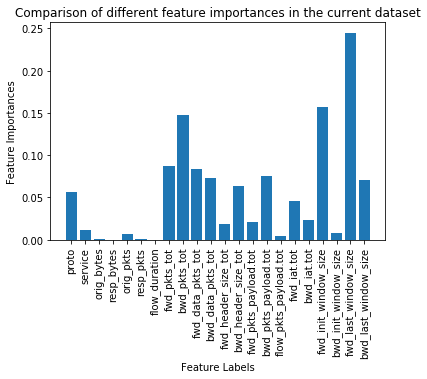

In [32]:
# Plor for the ExtraTreesClassifier output
plot.bar(x_columns, feature_importance_normalized)
plot.xlabel('Feature Labels')
plot.ylabel('Feature Importances')
plot.title('Comparison of different feature importances in the current dataset')
plot.xticks(rotation = 90)

# Plot size
plot.rcParams["figure.figsize"] = (70, 40)

plot.show()

In [33]:
import numpy as np

# Random state definition
random_state=42
np.random.seed(random_state)

In [34]:
from sklearn import metrics

# Classification Metrics: Accuracy, Recall, Precision & F1Score
def compute_metrics(y_test, pred):
    print('Accuracy:', metrics.accuracy_score(y_test, pred))
    print('Recall:', metrics.recall_score(y_test, pred, average = 'weighted'))
    print('Precision:', metrics.precision_score(y_test, pred, average = 'weighted'))
    print('F1-Score:', metrics.f1_score(y_test, pred, average = 'weighted'))

In [35]:
# Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

def extra_tree_classifier(x_train, y_train, x_columns):
    # Usage of ExtraTreesClassifier for feature selection
    extra_tree_forest = ExtraTreesClassifier(n_estimators=5, criterion='entropy', max_features=2, random_state=random_state)
    extra_tree_forest.fit(x_train, y_train)
    feature_importances = extra_tree_forest.feature_importances_
    feature_importance_normalized = np.std([tree.feature_importances_ for tree in  extra_tree_forest.estimators_], axis = 0)

    # Plot the feature importances
    plt.rcParams["figure.figsize"] = (70, 40)
    plt.bar(x_columns, feature_importance_normalized, align='center')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Importance')
    plt.title('Comparison of different feature importances in the current dataset')
    plt.xticks(rotation=90)
    plt.show()

In [36]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

ATTACKS = [
    'Apache Killer', 'ARP Spoofing', 
    'CAM Overflow', 'MQTT Malaria', 
    'Netscan', 'Normal', 
    'RUDY', 'SlowLoris', 
    'SlowRead'
]
    
def conf_matrix(y_test, prediction, array_dimension = 2):
    if (array_dimension == 2):
        predict_classes = np.argmax(prediction, axis = 1)
        expected_classes = np.argmax(y_test, axis = 1)
    elif (array_dimension == 1):
        predict_classes = prediction
        expected_classes = y_test
    
    cm = confusion_matrix(expected_classes, predict_classes)
    cmd = ConfusionMatrixDisplay(cm, display_labels=ATTACKS)

    # Plot size
    fig, ax = plt.subplots(figsize=(11,11))
    
    cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    
    # Add axis labels and rotate them
    ax.set_xlabel('Predicted labels', rotation=0, labelpad=20, fontsize=11)
    ax.set_ylabel('True labels', rotation=90, labelpad=20, fontsize=11)

    ax.tick_params(axis='x', pad=35)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='center', va='center')
    ax.tick_params(axis='y', pad=35)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=40, ha='center', va='center')
    
    # Adjust colorbar size
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=11)  # Adjust the font size of colorbar labels
    cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(cmd.im_, cax=cax)

In [37]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshowac(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

[METRICS] Decision Tree Classifier
Accuracy: 0.978926149899212
Recall: 0.978926149899212


/project/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9782405888442377
F1-Score: 0.9772179573639503

[CMATRIX] Decision Tree Confusion Matrix
CPU times: user 2.18 s, sys: 4.05 ms, total: 2.18 s
Wall time: 2.18 s


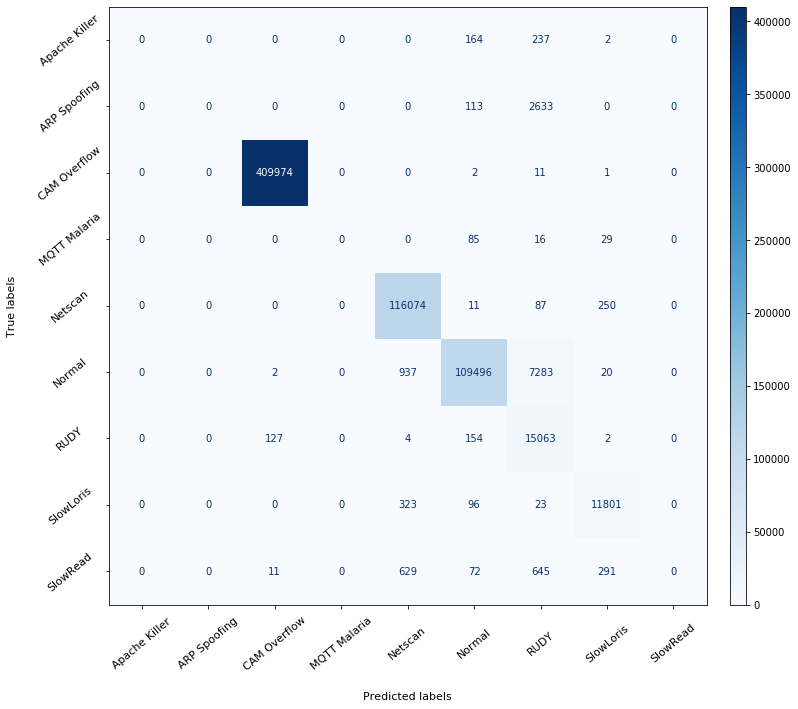

In [38]:
%%time

# Algorithm: DECISION TREE
from sklearn import tree

clf = tree.DecisionTreeClassifier(random_state=random_state, max_leaf_nodes=5)
clf = clf.fit(x_train, y_train)
tree_prediction = clf.predict(x_test)

print(f'[METRICS] Decision Tree Classifier')
compute_metrics(y_test, tree_prediction)

print(f'\n[CMATRIX] Decision Tree Confusion Matrix')
conf_matrix(y_test, tree_prediction, 1)

[TREE] Decision Tree Diagram


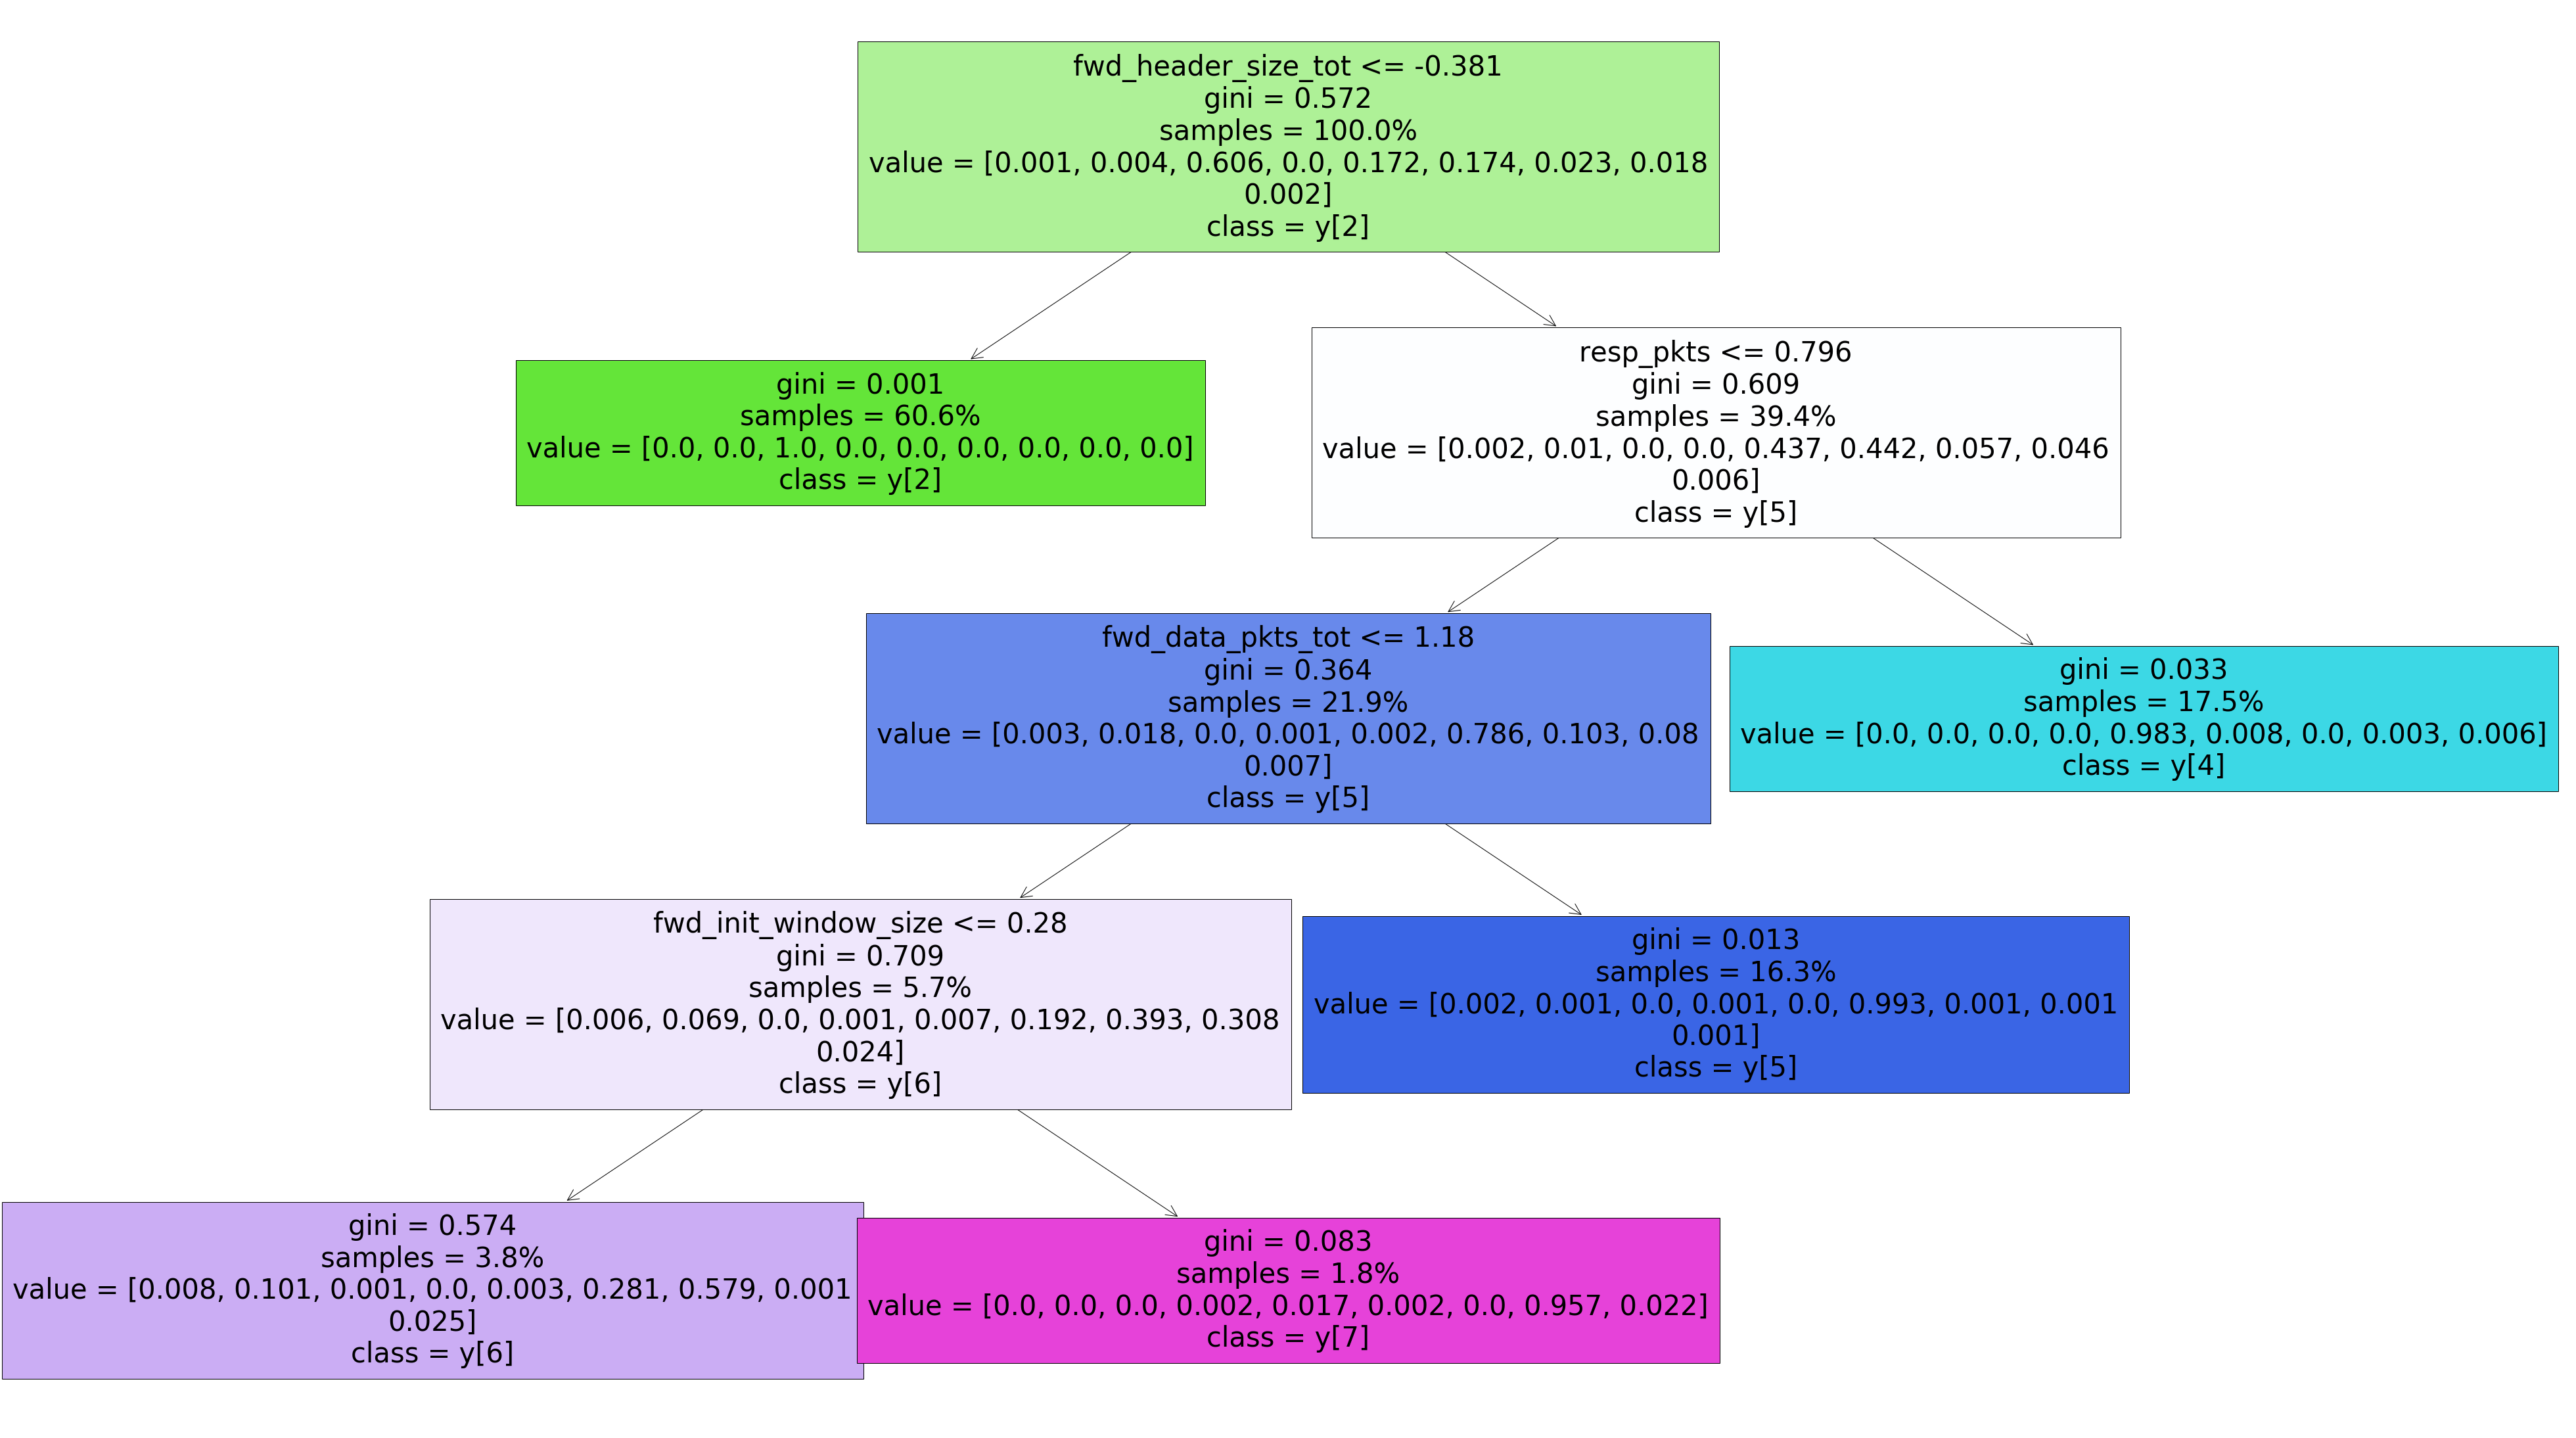

In [39]:
print(f'[TREE] Decision Tree Diagram')
tree.plot_tree(clf, feature_names=x_columns, class_names=True, filled=True, proportion=True)
plt.rcParams["figure.figsize"] = (90, 50)

[METRICS] Random Forest Classifier (Validation Set)
Accuracy: 0.9994694591734795
Recall: 0.9994694591734795
Precision: 0.999468440498343
F1-Score: 0.9994687323908934

[CMATRIX] Random Forest Confusion Matrix (Validation Set)
CPU times: user 3.96 s, sys: 0 ns, total: 3.96 s
Wall time: 3.96 s


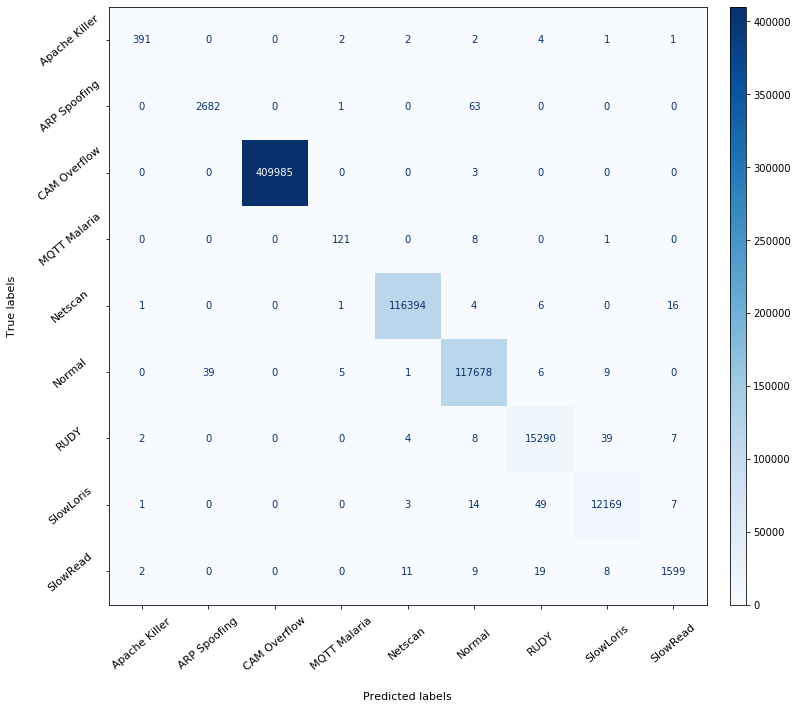

In [40]:
%%time

# Algorithm: RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

forest = RandomForestClassifier(n_estimators=5, random_state=random_state)
forest.fit(x_train, y_train)

# Validation
forest_validation_prediction = forest.predict(x_test)

print("[METRICS] Random Forest Classifier (Validation Set)")
compute_metrics(y_test, forest_validation_prediction)

print("\n[CMATRIX] Random Forest Confusion Matrix (Validation Set)")
conf_matrix(y_test, forest_validation_prediction, 1)

[METRICS] Decision Tree Classifier
Accuracy: 0.9994532030478758
Recall: 0.9994532030478758
Precision: 0.9994526481288375
F1-Score: 0.9994528867480922

[CMATRIX] Decision Tree Confusion Matrix
CPU times: user 3.61 s, sys: 16.4 ms, total: 3.63 s
Wall time: 3.63 s


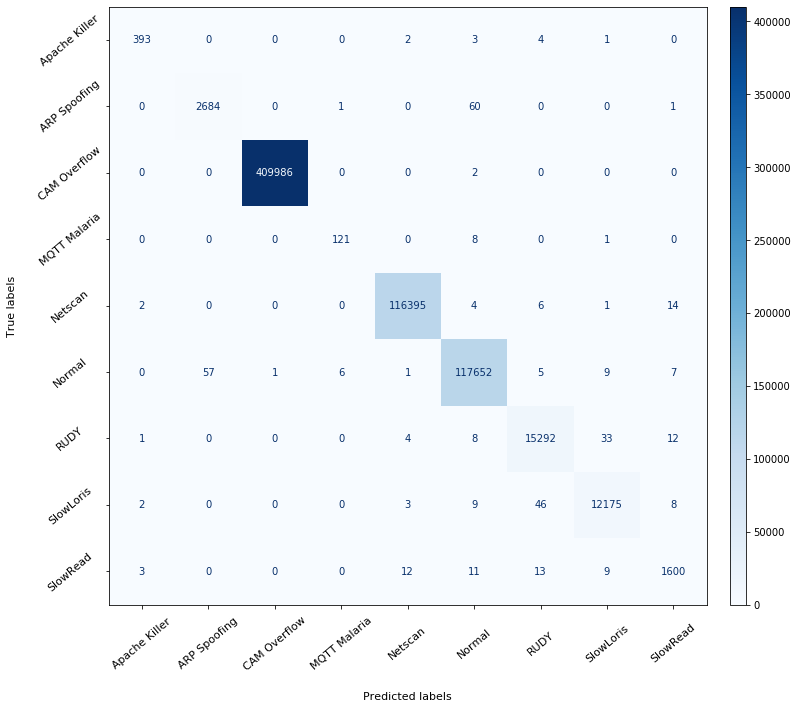

In [41]:
%%time

# Algorithm: DECISION TREE
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=random_state)
tree.fit(x_train, y_train)
tree_prediction = tree.predict(x_test)

print(f'[METRICS] Decision Tree Classifier')
compute_metrics(y_test, tree_prediction)

print(f'\n[CMATRIX] Decision Tree Confusion Matrix')
conf_matrix(y_test, tree_prediction, 1)